In [1]:
from qiskit.circuit import *
import numpy as np
from qiskit_aer import AerSimulator
from qiskit_aer.library import save_statevector
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit_aer.backends.backendproperties import AerBackendProperties
from qiskit.quantum_info import random_statevector, Statevector
from qiskit import transpile


In [2]:
p0 = np.random.random()
n=1
psi_L_vec = np.zeros(2**n)
psi_L_vec[0]=p0
psi_L_vec[-1]=np.sqrt(1-p0**2)
psi_L = Statevector(psi_L_vec)
psi_L = random_statevector(2)
print(psi_L)

Statevector([0.62640561-0.01632903j, 0.02059604-0.77905403j],
            dims=(2,))


In [3]:
def repetition3(q: Qubit, a1: Qubit, a2: Qubit) -> QuantumCircuit:
    qc = QuantumCircuit([q,a1,a2])
    qc.cx(q,a1)
    qc.cx(q,a2)
    qc.name = 'rep3'
    return qc
def recovery3(q: Qubit, a1: Qubit, a2: Qubit) -> QuantumCircuit:
    qc = QuantumCircuit([q,a1,a2])
    qc.cx(q,a1)
    qc.cx(q,a2)
    qc.ccx(a1,a2,q)
    qc.name = 'rep3'
    return qc

In [4]:
from qiskit.circuit.library import IGate
def noisyChannel(n: int, p: float, noise_model: NoiseModel) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    i = 0
    noise_model.add_all_qubit_quantum_error(pauli_error([('X', p), ('I', 1 - p)]),['id'])
    qc.id(i)
    
    # qc.y(bit_error)
    qc.name = "Noisy\nChannel"
    return qc

In [5]:
def encode():
    qc = QuantumCircuit(9)
    # encode for bit flip
    _q,_a1,_a2 = qc.qubits[0],qc.qubits[3],qc.qubits[6]
    qc.append(
        repetition3(_q,_a1,_a2),
        [_q,_a1,_a2],
        copy=False
    )
    qc.barrier()
    # project to Hadamard basis
    qc.h([qc.qubits[0],qc.qubits[3],qc.qubits[6]])
    qc.barrier()
    # encode for phase flip
    for j in [0,3,6]:
        _q,_a1,_a2 = qc.qubits[j],qc.qubits[j+1],qc.qubits[j+2]
        qc.append(
            repetition3(_q,_a1,_a2),
            [_q,_a1,_a2],
            copy=False
        )
    qc.name = 'enc9'
    return qc

def decode():
    qc = QuantumCircuit(9)
    for j in [0,3,6]:
        _q,_a1,_a2 = qc.qubits[j],qc.qubits[j+1],qc.qubits[j+2]
        qc.append(
            recovery3(_q,_a1,_a2),
            [_q,_a1,_a2],
            copy=False
        )
        qc.h(_q)
    qc.barrier()
    _q,_a1,_a2 = qc.qubits[0],qc.qubits[3],qc.qubits[6]
    qc.append(
        recovery3(_q,_a1,_a2),
        [_q,_a1,_a2],
        copy=False
    )
    qc.name = 'dec9'
    return qc


In [6]:
def shor9(inp: Statevector, noisy_channel: QuantumCircuit, decompose=False) -> QuantumCircuit:
    assert inp.num_qubits == 1
    qc = QuantumCircuit(3*3*1)
    qc.initialize(inp, qc.qubits[:1])
    _encode_qc = encode().decompose() if decompose else encode()
    qc.append(_encode_qc,qc.qubits, copy=False)
    qc.append(noisy_channel,qc.qubits)
    _decode_qc = decode().decompose() if decompose else decode()
    qc.append(_decode_qc,qc.qubits, copy=False)
    
    return qc


In [7]:

def control_circuit(inp: Statevector, noisy_channel: QuantumCircuit):
    """control circuit without any error"""
    qc = QuantumCircuit(9)
    qc.initialize(inp, qc.qubits[:1])
    qc.append(noisy_channel,qc.qubits)
    return qc

def retrieve(qc: QuantumCircuit, noise: NoiseModel):
    """destroy ancillas to retrieve only first bit's state"""
    qc.add_register(ClassicalRegister(1))
    qc.measure(qc.qubits[1:],[qc.clbits[0] for _ in qc.qubits[1:]])
    save_statevector(qc,label='test',pershot=True)
    NUM_SHOT = 100
    backend = AerSimulator()
    data = backend.run(
        # to not remove the consecutive CNOT 
        transpile(qc,backend,optimization_level=0),
        noisemodel = noise,
        shots=NUM_SHOT
        ).result().data()['test']
    return [list(filter(lambda x: x != 0j, np.asarray(vec))) for vec in data]

def calculate_error_rate(qc: QuantumCircuit, expect: Statevector, noise: NoiseModel) -> float:
    print(f"expect: {expect}")
    results = retrieve(qc, noise)
    print(results)
    # Iterate through measured result and count the ones that is not so different from expect
    # print(data)
    cmps = [all(
    [np.linalg.norm(state[0]- expect[0]) < 1e-6,
        np.linalg.norm(state[1]- expect[1]) < 1e-6]) 
        for state in results]
    return cmps.count(False)/float(len(cmps))

def run_single_epoch(p_e: float):
    expect_vec = random_statevector(2)
    _noise_model = NoiseModel()
    _pauli_noisy_chanel = noisyChannel(9, p_e, _noise_model)
    _shor9_qc = shor9(expect_vec, _pauli_noisy_chanel)
    _control_qc = control_circuit(expect_vec, _pauli_noisy_chanel)
    return calculate_error_rate(_shor9_qc, expect_vec, _noise_model), calculate_error_rate(_control_qc, expect_vec, _noise_model)

In [8]:
ps = np.arange(start=0.0, stop=1.0,step=0.1)
expect_vec = random_statevector(2)
noise = NoiseModel()
_pauli_noisy_chanel = noisyChannel(9, 0.5, noise)
def control_circuit(inp: Statevector, noisy_channel: QuantumCircuit):
    """control circuit without any error"""
    qc = QuantumCircuit(9)
    qc.initialize(inp, qc.qubits[:1])
    qc.append(noisy_channel,qc.qubits)
    return qc
for p_e in ps:
    _control_qc = control_circuit(expect_vec, _pauli_noisy_chanel)
    print(calculate_error_rate(_control_qc, expect_vec, noise))

expect: Statevector([ 0.96577157+0.16473654j, -0.19926487+0.02099178j],
            dims=(2,))
[[(0.9657715713044832+0.16473654164486226j), (-0.19926487154258962+0.020991781155379235j)], [(0.9657715713044832+0.16473654164486226j), (-0.19926487154258962+0.020991781155379235j)], [(0.9657715713044832+0.16473654164486226j), (-0.19926487154258962+0.020991781155379235j)], [(0.9657715713044832+0.16473654164486226j), (-0.19926487154258962+0.020991781155379235j)], [(0.9657715713044832+0.16473654164486226j), (-0.19926487154258962+0.020991781155379235j)], [(0.9657715713044832+0.16473654164486226j), (-0.19926487154258962+0.020991781155379235j)], [(0.9657715713044832+0.16473654164486226j), (-0.19926487154258962+0.020991781155379235j)], [(0.9657715713044832+0.16473654164486226j), (-0.19926487154258962+0.020991781155379235j)], [(0.9657715713044832+0.16473654164486226j), (-0.19926487154258962+0.020991781155379235j)], [(0.9657715713044832+0.16473654164486226j), (-0.19926487154258962+0.02099178115537923

In [9]:
run_single_epoch(0.9)

expect: Statevector([ 0.08598535-0.11330816j, -0.15734477-0.97724634j],
            dims=(2,))
[[(0.08598535113505354-0.11330815717857537j), (-0.15734476553677984-0.9772463382715499j)], [(0.08598535113505354-0.11330815717857537j), (-0.15734476553677984-0.9772463382715499j)], [(0.08598535113505354-0.11330815717857537j), (-0.15734476553677984-0.9772463382715499j)], [(0.08598535113505354-0.11330815717857537j), (-0.15734476553677984-0.9772463382715499j)], [(0.08598535113505354-0.11330815717857537j), (-0.15734476553677984-0.9772463382715499j)], [(0.08598535113505354-0.11330815717857537j), (-0.15734476553677984-0.9772463382715499j)], [(0.08598535113505354-0.11330815717857537j), (-0.15734476553677984-0.9772463382715499j)], [(0.08598535113505354-0.11330815717857537j), (-0.15734476553677984-0.9772463382715499j)], [(0.08598535113505354-0.11330815717857537j), (-0.15734476553677984-0.9772463382715499j)], [(0.08598535113505354-0.11330815717857537j), (-0.15734476553677984-0.9772463382715499j)], [(0.

(0.0, 0.0)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
expect: Statevector([-0.66581029-0.46834812j, -0.56575708-0.1313987j ],
            dims=(2,))
[[(-0.6658102917790812-0.46834812481797816j), (-0.5657570774734161-0.13139870101822734j)], [(-0.6658102917790812-0.46834812481797816j), (-0.5657570774734161-0.13139870101822734j)], [(-0.6658102917790812-0.46834812481797816j), (-0.5657570774734161-0.13139870101822734j)], [(-0.6658102917790812-0.46834812481797816j), (-0.5657570774734161-0.13139870101822734j)], [(-0.6658102917790812-0.46834812481797816j), (-0.5657570774734161-0.13139870101822734j)], [(-0.6658102917790812-0.46834812481797816j), (-0.5657570774734161-0.13139870101822734j)], [(-0.6658102917790812-0.46834812481797816j), (-0.5657570774734161-0.13139870101822734j)], [(-0.6658102917790812-0.46834812481797816j), (-0.5657570774734161-0.13139870101822734j)], [(-0.6658102917790812-0.46834812481797816j), (-0.5657570774734161-0.13139870101822734j)], [(-0.6658102917790812-0.46834812481797816j), (-0.565

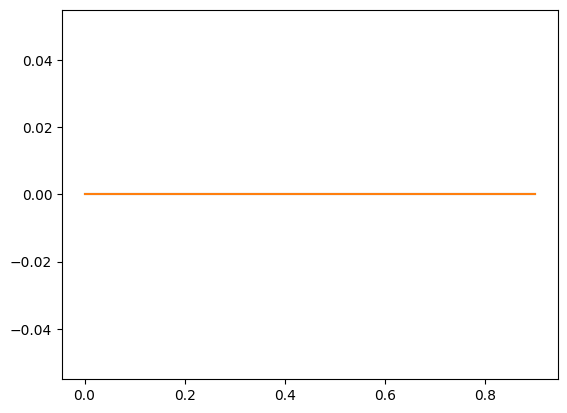

In [10]:
import matplotlib.pyplot as plt
ps = np.arange(start=0.0, stop=1.0,step=0.1)
print(ps)
ys = {'shor9': [], 'exp': []}
for p in ps:
    shor9_error_rate, control_error_rate = run_single_epoch(p)
    ys['shor9'].append(shor9_error_rate)
    ys['exp'].append(control_error_rate)
    
plt.plot(ps, ys['shor9'])
plt.plot(ps, ys['exp'])
